<div style = "color: white; background-color: black; border-radius: 10px; padding: 5px;"> <div style = "display: flex;"> <h1 style = "width: 80%; color: white;"> Data Science 1 - Group Project </h1> <div style = "width: 20%; text-align: center; font-size: 10px;"> Kenneth Dang, Carson Dial, Robert Duque,Aryan Kondapalli <br> Christopher Eick <br> Data Science I (COSC 3337) <br> November 22, 2022</div> </div> </div>

## Setting Things Up:

Below, we attempt to import the respective libraries we will be using in this project:

In [30]:
# Libraries to Use:
import warnings
from mpl_toolkits.basemap import Basemap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.neighbors
import scipy as sp
import scipy.stats
import numpy as np
import mpl_toolkits
import math
import sklearn
import folium
from folium.plugins import HeatMap, HeatMapWithTime
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from collections import Counter

# For Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

Now, we'll attempt to import the data set from the files handed by the TA. Each of the data sets represents a batch: 

In [20]:
# Loading the Data Set from Teams (Dataset and Code Folder → Files → Contiguous Earthquakes in USA):
batches = {
    'batch1': pd.concat([pd.read_csv("data/US_Earthquakes/Earthquake_2021_1_2021_2_filtered.csv"), pd.read_csv("data/US_Earthquakes/Earthquake_2022_1_2022_2_filtered.csv")]),
    'batch2': pd.concat([pd.read_csv("data/US_Earthquakes/Earthquake_2021_3_2021_4_filtered.csv"), pd.read_csv("data/US_Earthquakes/Earthquake_2022_3_2022_4_filtered.csv")]),
    'batch3': pd.concat([pd.read_csv("data/US_Earthquakes/Earthquake_2021_5_2021_6_filtered.csv"), pd.read_csv("data/US_Earthquakes/Earthquake_2022_5_2022_6_filtered.csv")]),
    'batch4': pd.concat([pd.read_csv("data/US_Earthquakes/Earthquake_2021_7_2021_8_filtered.csv"), pd.read_csv("data/US_Earthquakes/Earthquake_2022_7_2022_8_filtered.csv")]),
    'batch5': pd.concat([pd.read_csv("data/US_Earthquakes/Earthquake_2020_9_2020_10_filtered.csv"), pd.read_csv("data/US_Earthquakes/Earthquake_2021_9_2021_10_filtered.csv")]),
    'batch6': pd.concat([pd.read_csv("data/US_Earthquakes/Earthquake_2020_11_2020_12_filtered.csv"), pd.read_csv("data/US_Earthquakes/Earthquake_2021_11_2021_12_filtered.csv")])
}

# Using a list to differentiate months of all 6 batches
months = ['Jan-Feb', 'Mar-Apr', 'May-Jun', 'Jul-Aug', 'Sep-Oct', 'Nov-Dec']

As our instruction mentioned, we would have to use a sliding window of 3 batches for each batch, so we write the following code below:

For convenience we also create the following dictionary below:

In [21]:
setAndNames = dict()

j = 0
for i in batches:
    setAndNames[months[j]] = batches[i]
    j += 1

# Let's seperate the date and time of the time feature in the datasets to better understand when the earthquake is happening
for i in setAndNames:
    dateTimes = []
    for index, row in setAndNames[i].iterrows():
        dateTimes.append(int(row['time'][0:-5].replace('T', '').replace('-', '').replace(':', '')))
    setAndNames[i] = setAndNames[i].drop(['time'], axis = 1)
    setAndNames[i]['dateTime'] = dateTimes
    setAndNames[i] = setAndNames[i].iloc[:,[4,0,1,2,3]]

    
# Let's print out the first and last set to see if the data is oriented the way we want it
print(setAndNames['Jan-Feb'])

           dateTime   latitude   longitude     depth   mag
0    20210101012324  32.301900 -101.798200  5.000000  3.10
1    20210101013114  35.034667  -97.832500  9.420000  2.76
2    20210101022717  34.879500 -110.779700  5.000000  2.70
3    20210101044935  32.285400 -101.808700  5.000000  2.60
4    20210101052606  44.080800 -114.981200  3.000000  3.90
..              ...        ...         ...       ...   ...
373  20220227151718  35.544000  -96.747500  7.800000  2.64
374  20220227210322  43.902700 -105.343900  0.000000  3.10
375  20220228005223  31.760486 -104.642998  4.923291  3.00
376  20220228030417  31.606294 -104.320863  7.314136  2.60
377  20220228191323  38.582167 -112.209667 -2.920000  2.70

[814 rows x 5 columns]


In [22]:
def EpsAndMin(min_s, epsil, window):
    output = []
    for ms in min_s:
        for ep in epsil:
            labels = DBSCAN(min_samples=ms, eps = ep).fit(window[['latitude','longitude']]).labels_
            score = silhouette_score(window[['latitude','longitude']], labels)
            output.append((ms, ep, score))
    min_s, epsil, score = sorted(output, key = lambda x:x[-1])[-1]

    print(f"Best silhouette_score: {score}")
    print(f"min_samples: {min_s}")
    print(f"eps: {epsil}")
    return min_s, epsil

min_samples = range(30,50,5)
eps = np.arange(.5, 1.1, .1)
minS = {}
epsi = {}

for i in range(0, len(batches)):
    print(months[i])
    minS[i], epsi[i] = EpsAndMin(min_samples, eps, setAndNames[months[i]])
    print('\n')

Jan-Feb
Best silhouette_score: 0.3925925627855103
min_samples: 30
eps: 1.0999999999999999


Mar-Apr
Best silhouette_score: 0.39222553329063614
min_samples: 30
eps: 1.0999999999999999


May-Jun
Best silhouette_score: 0.398574932508512
min_samples: 30
eps: 1.0999999999999999


Jul-Aug
Best silhouette_score: 0.5608359878485536
min_samples: 30
eps: 0.9999999999999999


Sep-Oct
Best silhouette_score: 0.5733536002616471
min_samples: 30
eps: 1.0999999999999999


Nov-Dec
Best silhouette_score: 0.5142199932256724
min_samples: 30
eps: 1.0999999999999999




The algorithm below utilizes DBSCAN to cluster our data and visualize on a geographic map what the clustering looks like. I chose DBSCAN because we want to take into consideration the outliers in our clustering.

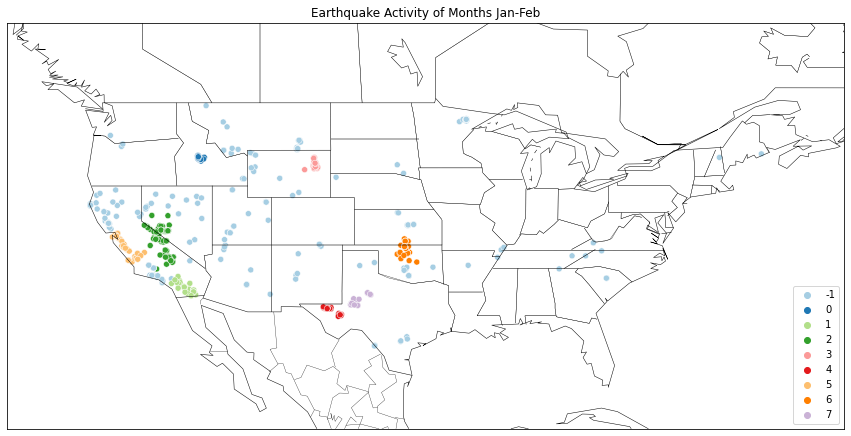

Clusters:  Counter({2: 169, 4: 146, 0: 61, 1: 56, 5: 55, 3: 45, 6: 33, 7: 31})


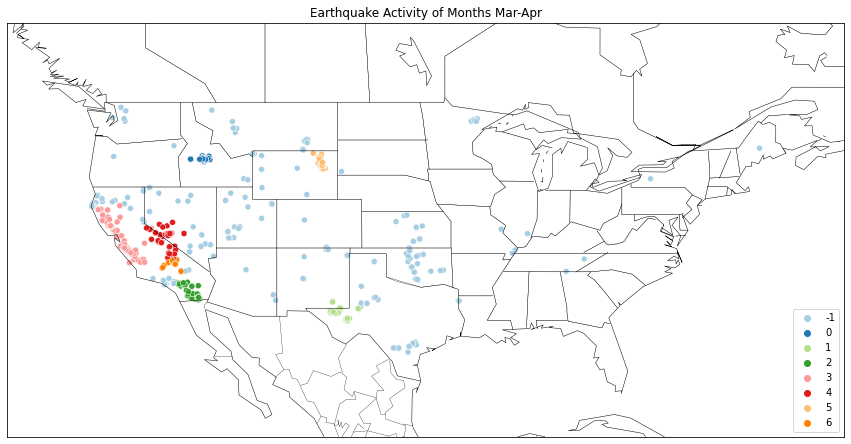

Clusters:  Counter({1: 216, 3: 109, 4: 89, 0: 71, 5: 69, 2: 50, 6: 23})


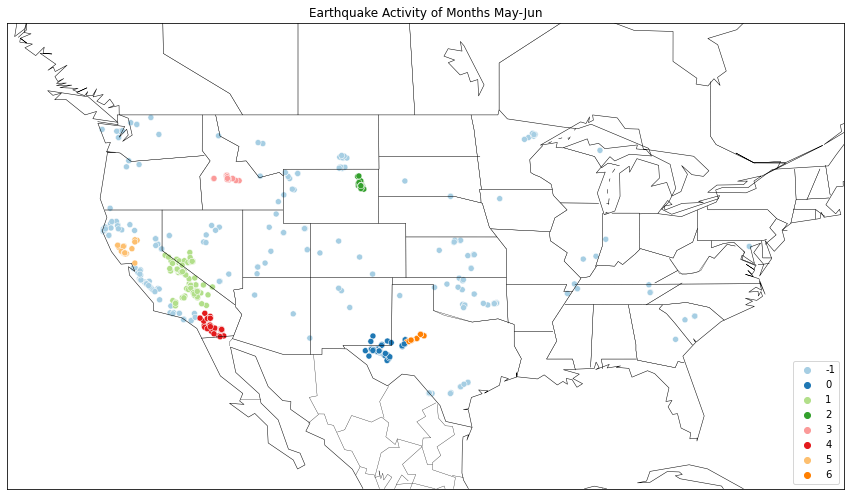

Clusters:  Counter({0: 245, 4: 168, 1: 131, 2: 34, 3: 32, 5: 31, 6: 22})


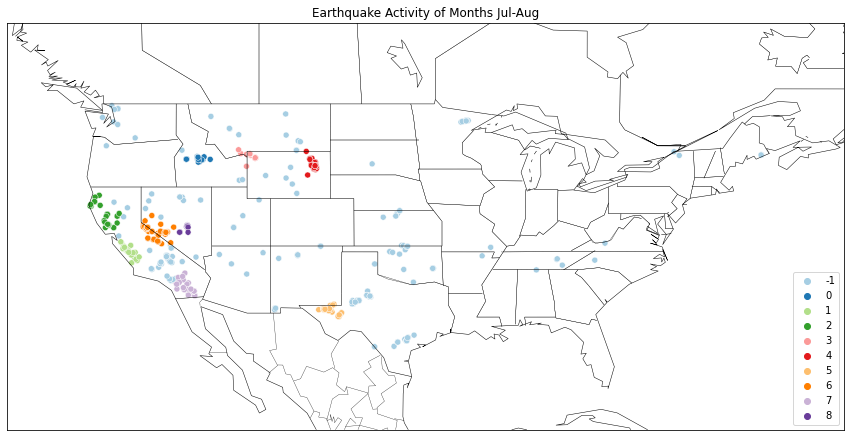

Clusters:  Counter({6: 321, 5: 194, 2: 53, 7: 46, 0: 37, 1: 37, 4: 35, 3: 34, 8: 31})


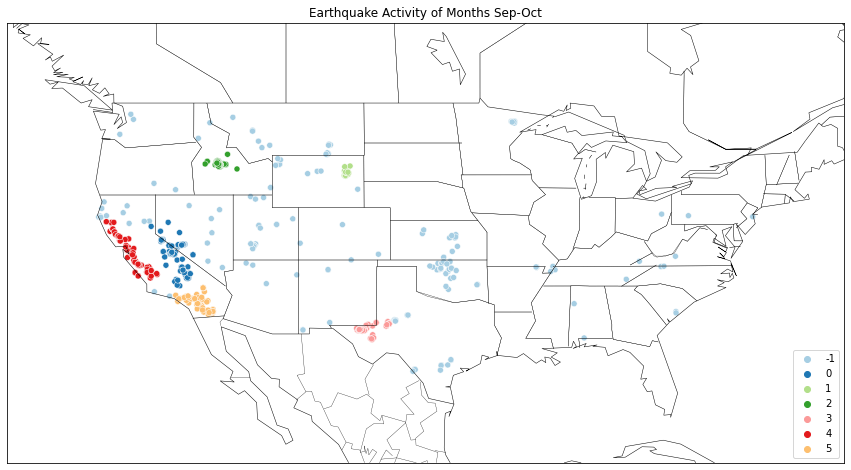

Clusters:  Counter({5: 252, 3: 195, 0: 184, 2: 134, 4: 108, 1: 31})


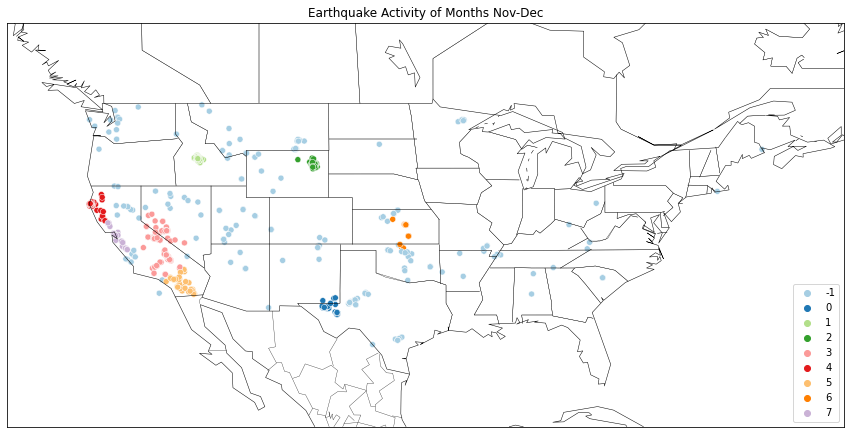

Clusters:  Counter({3: 292, 1: 151, 0: 133, 4: 81, 6: 47, 7: 45, 2: 44, 5: 43})


In [23]:
warnings.filterwarnings("ignore")

# Function to Cluster Sets:

def DBCluster(window, t, min_s, eps):
    # Setting the title for the plot:
    figure = plt.figure(figsize=(15, 15))
    plt.title("Earthquake Activity of Months {}".format(t)) #TODO: ADD TITLE NAME FOR EACH SET

    # Setting values for Density-Based Clustering:
    
    epsilon = eps # We set the value of ε for density based scan here.
    minPts = min_s # We set the value of γ for the density based scan here. So core points need 100 points within ε distance of it.

    # Creating Clusters:
    df_all_den = window[['latitude', 'longitude']]
    db = DBSCAN(eps = epsilon, min_samples = minPts).fit(df_all_den)
    cluster_labels = db.labels_

    # Showing Clusters
    clustering_map = mpl_toolkits.basemap.Basemap(
        projection = 'cyl', # We use cylindrical equal-area projection because it is a common projection.

        # We set minimum and maximum boundaries for longitude:
        llcrnrlat = setAndNames[t]['latitude'].min()-7, urcrnrlat = setAndNames[t]['latitude'].max()+7,
        # We set minimum and maximum boundaries for latitude:
        llcrnrlon = setAndNames[t]['longitude'].min()-7,urcrnrlon = setAndNames[t]['longitude'].max()+7,
        resolution = 'c'
    )

    # Methods to make map more detailed:
    clustering_map.drawcoastlines(linewidth = .5)
    clustering_map.drawcountries(linewidth = .5)
    clustering_map.drawstates(linewidth = .3)
    sns.scatterplot(data = df_all_den[['latitude', 'longitude']], x="longitude", y="latitude", hue=cluster_labels, legend="full", palette=sns.color_palette("Paired"))
    plt.legend(loc = 'lower right') # Place legend in the lower right corner.

    # Outputting / Showing Map:
    plt.show()

    c = Counter(cluster_labels)
    del c[-1]
    print("Clusters: ", c)

# Driver Function:
for i,t in enumerate(setAndNames):
    DBCluster(setAndNames[t], t, minS[i], epsi[i])

In the above, we had ran the clustering based algorithm with an optimal value for $\varepsilon$ to calculate the high density. Our methadology for constructing the medium-based density threshold is to leave $\gamma$ the same and reduce the radius, by doing a new value of $\varepsilon$ given by $\frac{\varepsilon}{2}$. We rerun the code above with this new value and output each map:

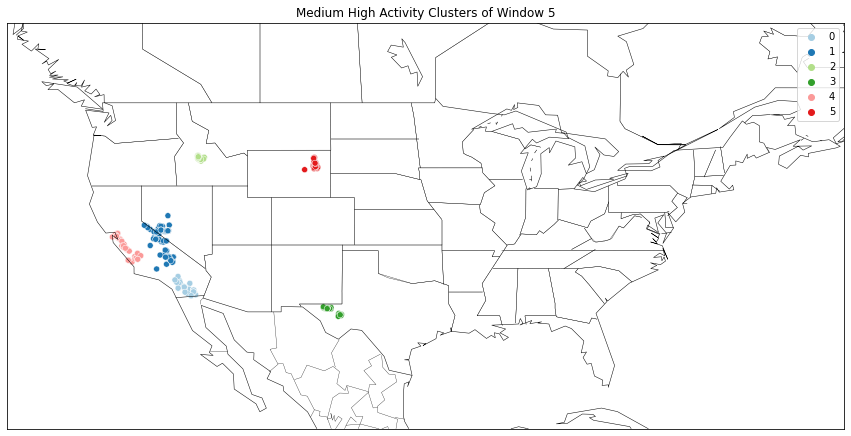

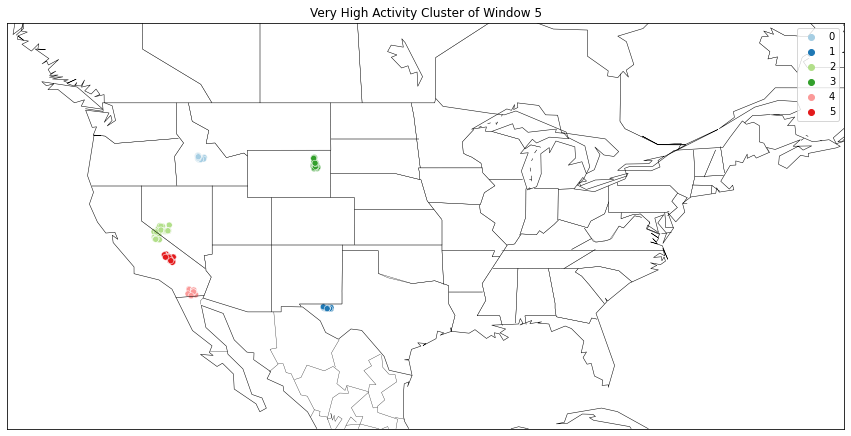

4884


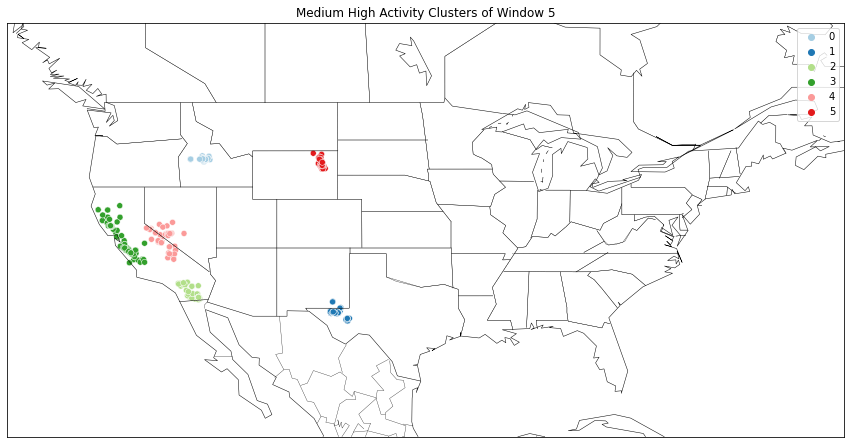

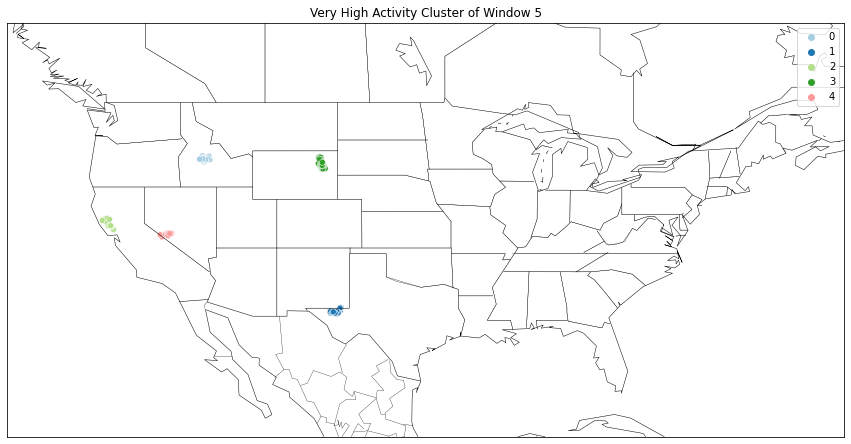

5292


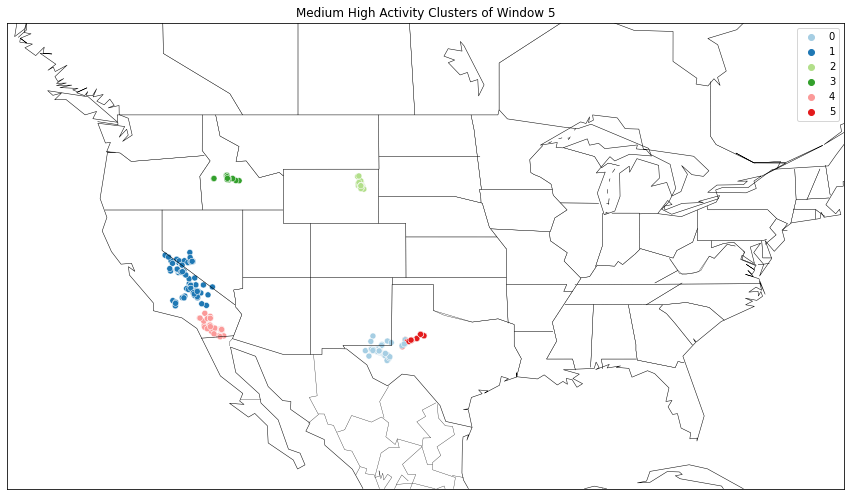

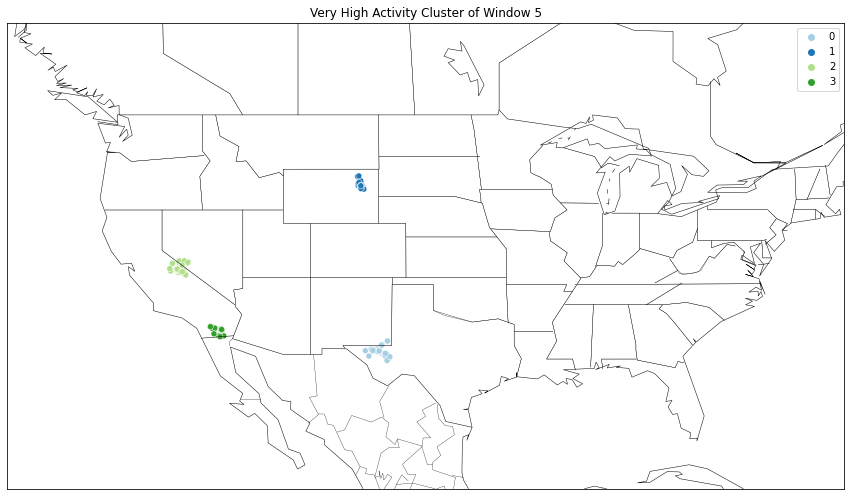

5514


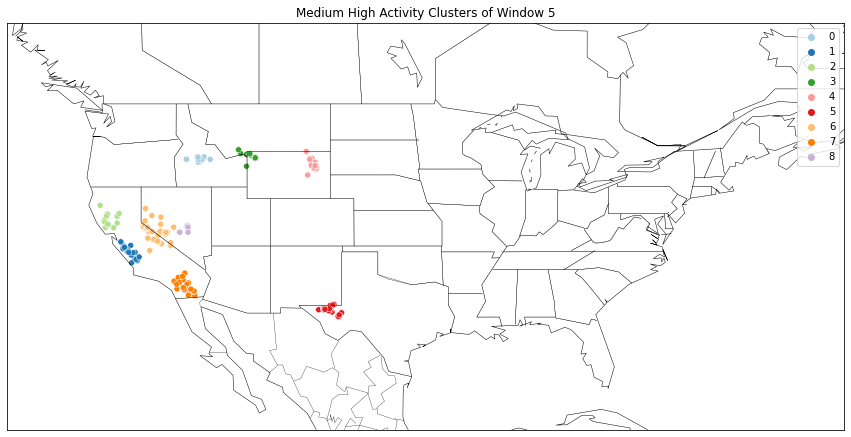

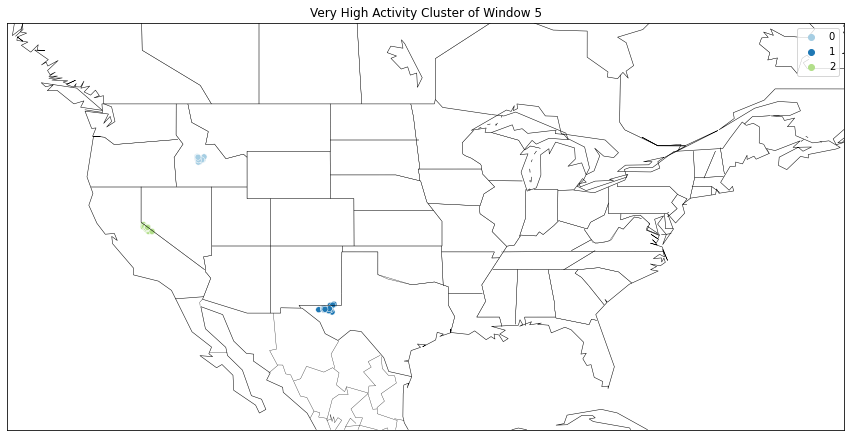

5982


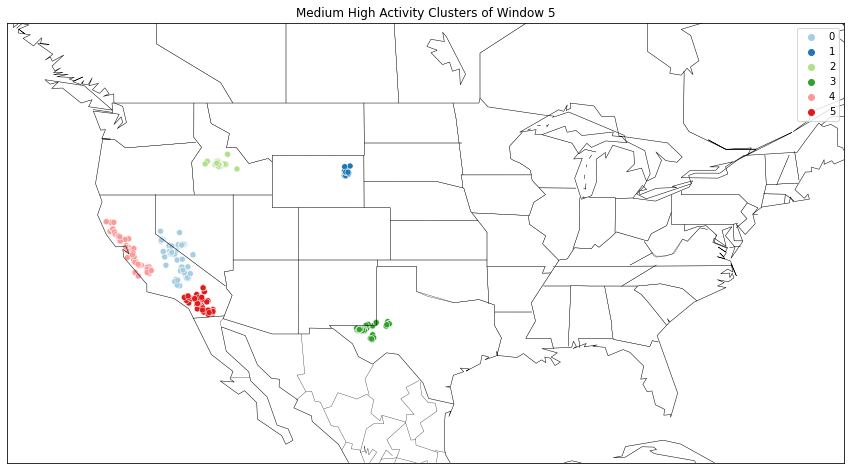

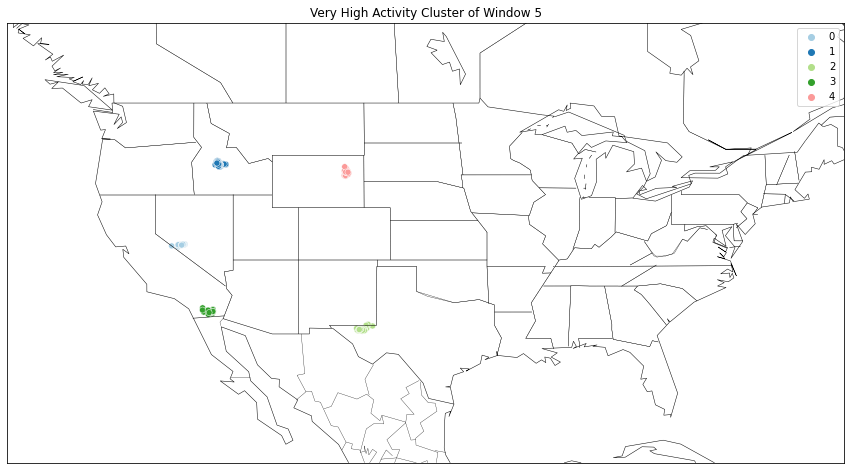

6618


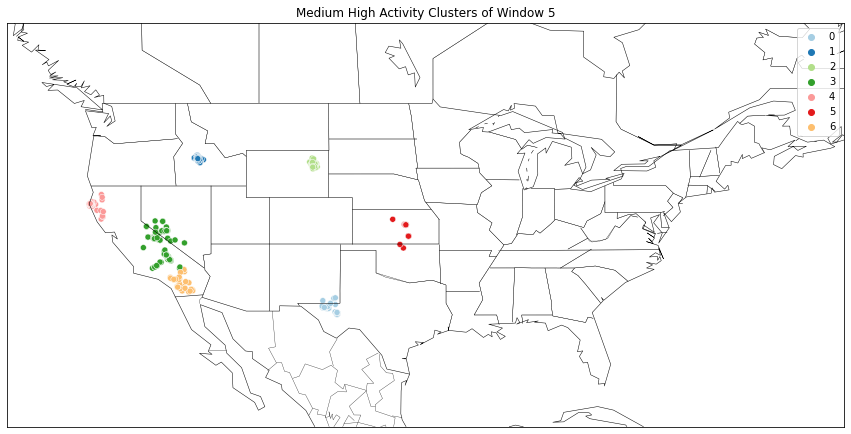

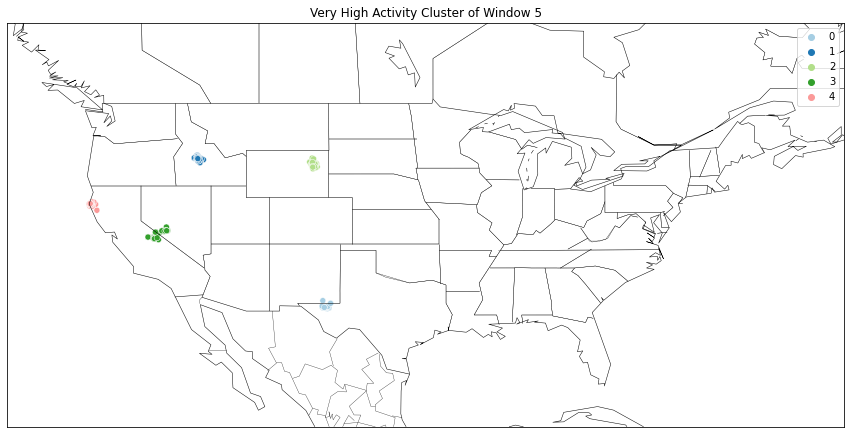

6282


In [24]:
warnings.filterwarnings("ignore")

def returnMedHigh(window, t):
    figure = plt.figure(figsize=(15, 15))
    plt.title("Medium High Activity Clusters of Window " + str(i));
    epsilon = epsi[i]
    minPts = minS[i]

    df_all_den = window[['latitude', 'longitude', 'mag']] 
    db = DBSCAN(eps = epsilon, min_samples = minPts).fit(df_all_den) 
    cluster_labels = np.where(db.labels_ != -1)
    labels = db.labels_[db.labels_ != -1]
    plotArray = df_all_den.iloc[cluster_labels]
    clustering_map = mpl_toolkits.basemap.Basemap(
        projection = 'cyl', 
        llcrnrlat = setAndNames[t]['latitude'].min()-7, urcrnrlat = setAndNames[t]['latitude'].max()+7,
        llcrnrlon = setAndNames[t]['longitude'].min()-7,urcrnrlon = setAndNames[t]['longitude'].max()+7,
        resolution = 'c'
    )

    clustering_map.drawcoastlines(linewidth = .5)
    clustering_map.drawcountries(linewidth = .5)
    clustering_map.drawstates(linewidth = .3)
    sns.scatterplot(data = plotArray[['latitude', 'longitude']], x="longitude", y="latitude", hue=labels, legend="full", palette=sns.color_palette("Paired"))
    plt.show()
    returnArray = window
    returnArray['cluster'] = db.labels_
    return returnArray

def returnVeryHigh(window, t):
    figure = plt.figure(figsize=(15, 15))
    plt.title("Very High Activity Cluster of Window " + str(i));
    epsilon = epsi[i]/2
    minPts = minS[i]

    df_all_den = window[['latitude', 'longitude', 'mag']] 
    db = DBSCAN(eps = epsilon, min_samples = minPts).fit(df_all_den) 
    cluster_labels = np.where(db.labels_ != -1)
    labels = db.labels_[db.labels_ != -1]
    plotArray = df_all_den.iloc[cluster_labels]
    clustering_map = mpl_toolkits.basemap.Basemap(
        projection = 'cyl', 
        llcrnrlat = setAndNames[t]['latitude'].min()-7, urcrnrlat = setAndNames[t]['latitude'].max()+7,
        llcrnrlon = setAndNames[t]['longitude'].min()-7,urcrnrlon = setAndNames[t]['longitude'].max()+7,
        resolution = 'c'
    )

    clustering_map.drawcoastlines(linewidth = .5)
    clustering_map.drawcountries(linewidth = .5)
    clustering_map.drawstates(linewidth = .3)
    sns.scatterplot(data = plotArray[['latitude', 'longitude']], x="longitude", y="latitude", hue=labels, legend="full", palette=sns.color_palette("Paired"))
    plt.show()
    returnArray = window
    returnArray['cluster'] = db.labels_
    
    print(returnArray.size)
    return returnArray, db

returnHotSpots = {}

for t in setAndNames:
    returnHotSpots["medHigh_"+t] = returnMedHigh(setAndNames[t], t)
    returnHotSpots["veryHigh_"+t], temp = returnVeryHigh(setAndNames[t], t)


In [75]:
# Working with one model at a time

models = dict()
scales = dict()
scaler = StandardScaler()

for i in setAndNames:
    modelName = 'model_'+str(i)
    scaleName = 'scale_'+str(i)
    Y = setAndNames[i]['cluster']
    X = scaler.fit_transform(setAndNames[i].drop(['cluster', 'dateTime', 'mag', 'depth'], axis = 1))
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3, random_state = 0)
    
    scale = scaler.fit(setAndNames[i].drop(['cluster', 'dateTime', 'mag', 'depth'], axis = 1))
    scales[scaleName] = scale
    
    paramGrid = {
        'C': [0.1, 1, 10, 100, 1000], 
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }
    
    gridSearch = GridSearchCV(SVC(), param_grid = paramGrid, refit = True, cv = 6, verbose = 1)
    gridResult = gridSearch.fit(trainX, trainY)
    print('Best score for '+ modelName + ': ')
    print(gridResult.best_score_)
    print('\n')
    
    model = SVC(C = gridResult.best_params_['C'], gamma = gridResult.best_params_['gamma'], kernel = gridResult.best_params_['kernel'])
    models[modelName] = model.fit(trainX, trainY)


Fitting 6 folds for each of 25 candidates, totalling 150 fits
Best score for model_Jan-Feb: 
0.9630832400149308


Fitting 6 folds for each of 25 candidates, totalling 150 fits
Best score for model_Mar-Apr: 
0.9789009454914653


Fitting 6 folds for each of 25 candidates, totalling 150 fits
Best score for model_May-Jun: 
0.9767076266297451


Fitting 6 folds for each of 25 candidates, totalling 150 fits
Best score for model_Jul-Aug: 
0.9870812457019352


Fitting 6 folds for each of 25 candidates, totalling 150 fits
Best score for model_Sep-Oct: 
0.9805595930232558


Fitting 6 folds for each of 25 candidates, totalling 150 fits
Best score for model_Nov-Dec: 
0.971311475409836


{'model_Jan-Feb': SVC(C=1000, gamma=1), 'model_Mar-Apr': SVC(C=1000, gamma=1), 'model_May-Jun': SVC(C=100, gamma=1), 'model_Jul-Aug': SVC(C=1000, gamma=1), 'model_Sep-Oct': SVC(C=1000, gamma=1), 'model_Nov-Dec': SVC(C=1000, gamma=1)}


In [82]:
# Let's try to predict the cluster of an input date time and longitude and latitude
lat = 32.301901
lon = -101.798199

scaledInput = scales['scale_Jan-Feb'].transform([[lat, lon]])
print(models['model_Jan-Feb'].predict([[scaledInput[0][0], scaledInput[0][1]]]))

[-1]


In [40]:
print('Best Parameters: ')
print(gridResult.best_params_)
print(gridResult.best_score_)

Best Parameters: 
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.950802538260545


<hr> <h1>Heat Maps Over Windows and Predictions:</h1>

Now, below, we attempt to create a heatmap of each of the following. We create the `heatmap()` object from `Folium` library below:

In [10]:
# Creating Heatmap Object:
hm = folium.Map(location=[37.0902, -95.7129], zoom_start=4.2, tiles='stamentoner')

# Outputting Heatmap:
HeatMap(window1[["latitude", "longitude","mag"]], min_opacity=0.4, blur=18).add_to(folium.FeatureGroup(name='Heat Map').add_to(hm))
folium.LayerControl().add_to(hm)

In [11]:
# Preprocessing Stuff:
window1temp = window1
window1temp["batch"] = 1
window1temp = window1temp[["latitude", "longitude", "mag", "batch"]]
window2temp = window2
window2temp["batch"] = 2
window2temp = window2temp[["latitude", "longitude", "mag", "batch"]]
window3temp = window3
window3temp["batch"] = 3
window3temp = window3temp[["latitude", "longitude", "mag", "batch"]]
window4temp = window4
window4temp["batch"] = 4
window4temp = window4temp[["latitude", "longitude", "mag", "batch"]]
window5temp = window5
window5temp["batch"] = 5
window5temp = window5temp[["latitude", "longitude", "mag", "batch"]]
window6temp = window6
window6temp["batch"] = 6
window6temp = window6temp[["latitude", "longitude", "mag", "batch"]]
window7temp = window7
window7temp["batch"] = 7
window7temp = window7temp[["latitude", "longitude", "mag", "batch"]]
window8temp = window8
window8temp["batch"] = 8
window8temp = window8temp[["latitude", "longitude", "mag","batch"]]
window9temp = window9
window9temp["batch"] = 9
window9temp = window9temp[["latitude", "longitude", "mag", "batch"]]
window10temp = window10
window10temp["batch"] = 10
window10temp = window10temp[["latitude", "longitude", "mag", "batch"]]

# Creating a set of all earthquake activities:
fullSet = [window1temp, window2temp, window3temp, window4temp, window5temp, window6temp, window7temp, window8temp, window9temp, window10temp]
fullSetMerged = pd.concat(fullSet) # Converting it to a Pandas Dataframe.

hmtdata = []
for _, d in fullSetMerged.groupby("batch"):
    hmtdata.append([[row['latitude'], row['longitude'], row["mag"]] for _, row in d.iterrows()])

# Creating Heatmap Object:
hmt = folium.Map(location=[37.0902, -95.7129], zoom_start=4.2, tiles='stamentoner', control_scale=True)

# Extra Methods to Run on Our Heatmap:
HeatMapWithTime(hmtdata,auto_play=True,radius=10,use_local_extrema=True).add_to(hmt)

# Output the Heatmap:
hmt

Here we animate the following heatmap for each of the windows.

Now, we create a heat map below to animate the sliding windows of medium-threshold density hot spots by rerunning some the code above:

In [12]:
# Heat map animation for medium high hot spots
window1temp = returnHotSpots["medHigh0"]
window1temp["batch"] = 1
window1temp = window1temp[["latitude", "longitude", "mag", "batch"]]
window2temp = returnHotSpots["medHigh1"]
window2temp["batch"] = 2
window2temp = window2temp[["latitude", "longitude", "mag", "batch"]]
window3temp = returnHotSpots["medHigh2"]
window3temp["batch"] = 3
window3temp = window3temp[["latitude", "longitude", "mag", "batch"]]
window4temp = returnHotSpots["medHigh3"]
window4temp["batch"] = 4
window4temp = window4temp[["latitude", "longitude", "mag", "batch"]]
window5temp = returnHotSpots["medHigh4"]
window5temp["batch"] = 5
window5temp = window5temp[["latitude", "longitude", "mag", "batch"]]
window6temp = returnHotSpots["medHigh5"]
window6temp["batch"] = 6
window6temp = window6temp[["latitude", "longitude", "mag", "batch"]]
window7temp = returnHotSpots["medHigh6"]
window7temp["batch"] = 7
window7temp = window7temp[["latitude", "longitude", "mag", "batch"]]
window8temp = returnHotSpots["medHigh7"]
window8temp["batch"] = 8
window8temp = window8temp[["latitude", "longitude", "mag", "batch"]]
window9temp = returnHotSpots["medHigh8"]
window9temp["batch"] = 9
window9temp = window9temp[["latitude", "longitude", "mag", "batch"]]
window10temp = returnHotSpots["medHigh9"]
window10temp["batch"] = 10
window10temp = window10temp[["latitude", "longitude", "mag", "batch"]]

fullSet = [window1temp, window2temp, window3temp, window4temp, window5temp, window6temp, window7temp, window8temp, window9temp, window10temp]
fullSetMerged = pd.concat(fullSet)

hmtdata = []
for _, d in fullSetMerged.groupby("batch"):
    hmtdata.append([[row['latitude'], row['longitude'], row["mag"]] for _, row in d.iterrows()])


hmt = folium.Map(location=[37.0902, -95.7129], zoom_start = 4.2, tiles='stamentoner', control_scale=True)

HeatMapWithTime(hmtdata,auto_play=True,radius=10,use_local_extrema=True).add_to(hmt)
print("HeatMap of Medium High Clusters for Contiguous USA")
print("\n***TIME SERIES***")
print("1: September 2020 - February 2021")
print("1: November 2020 - April 2021")
print("1: January 2021 - June 2021")
print("1: March 2021 - August 2021")
print("1: May 2021 - October 2021")
print("1: July 2021 - December 2021")
print("1: September 2021 - February 2022")
print("1: November 2021 - April 2022")
print("1: January 2022 - June 2022")
print("1: March 2022 - August 2022")
hmt

HeatMap of Medium High Clusters for Contiguous USA

***TIME SERIES***
1: September 2020 - February 2021
1: November 2020 - April 2021
1: January 2021 - June 2021
1: March 2021 - August 2021
1: May 2021 - October 2021
1: July 2021 - December 2021
1: September 2021 - February 2022
1: November 2021 - April 2022
1: January 2022 - June 2022
1: March 2022 - August 2022


Lastly, we create an animation for the high density threshold hotspots, again by running some of the values above:

In [13]:
# Heat Map Animation for High Density Threshold Spots:

# Preprocessing Stuff:
window1temp = returnHotSpots["veryHigh0"]
window1temp["batch"] = 1
window1temp = window1temp[["latitude", "longitude", "mag", "batch"]]
window2temp = returnHotSpots["veryHigh1"]
window2temp["batch"] = 2
window2temp = window2temp[["latitude", "longitude", "mag", "batch"]]
window3temp = returnHotSpots["veryHigh2"]
window3temp["batch"] = 3
window3temp = window3temp[["latitude", "longitude", "mag", "batch"]]
window4temp = returnHotSpots["veryHigh3"]
window4temp["batch"] = 4
window4temp = window4temp[["latitude", "longitude", "mag", "batch"]]
window5temp = returnHotSpots["veryHigh4"]
window5temp["batch"] = 5
window5temp = window5temp[["latitude", "longitude", "mag", "batch"]]
window6temp = returnHotSpots["veryHigh5"]
window6temp["batch"] = 6
window6temp = window6temp[["latitude", "longitude", "mag", "batch"]]
window7temp = returnHotSpots["veryHigh6"]
window7temp["batch"] = 7
window7temp = window7temp[["latitude", "longitude", "mag", "batch"]]
window8temp = returnHotSpots["veryHigh7"]
window8temp["batch"] = 8
window8temp = window8temp[["latitude", "longitude", "mag", "batch"]]
window9temp = returnHotSpots["veryHigh8"]
window9temp["batch"] = 9
window9temp = window9temp[["latitude", "longitude", "mag", "batch"]]
window10temp = returnHotSpots["veryHigh9"]
window10temp["batch"] = 10
window10temp = window10temp[["latitude", "longitude", "mag", "batch"]]


fullSet = [window1temp, window2temp, window3temp, window4temp, window5temp, window6temp, window7temp, window8temp, window9temp, window10temp]
fullSetMerged = pd.concat(fullSet)

hmtdata = []
for _, d in fullSetMerged.groupby("batch"):
    hmtdata.append([[row['latitude'], row['longitude'], row["mag"]] for _, row in d.iterrows()])

hmt = folium.Map(location=[37.0902, -95.7129], zoom_start=4.2, tiles='stamentoner', control_scale=True)

HeatMapWithTime(hmtdata,auto_play=True,radius=10,use_local_extrema=True).add_to(hmt)
print("HeatMap of Very High Clusters for Contiguous USA")
print("\n***TIME SERIES***")
print("1: September 2020 - February 2021")
print("1: November 2020 - April 2021")
print("1: January 2021 - June 2021")
print("1: March 2021 - August 2021")
print("1: May 2021 - October 2021")
print("1: July 2021 - December 2021")
print("1: September 2021 - February 2022")
print("1: November 2021 - April 2022")
print("1: January 2022 - June 2022")
print("1: March 2022 - August 2022")
hmt

HeatMap of Very High Clusters for Contiguous USA

***TIME SERIES***
1: September 2020 - February 2021
1: November 2020 - April 2021
1: January 2021 - June 2021
1: March 2021 - August 2021
1: May 2021 - October 2021
1: July 2021 - December 2021
1: September 2021 - February 2022
1: November 2021 - April 2022
1: January 2022 - June 2022
1: March 2022 - August 2022


<hr> <br><h1>Data Science 1 (Extra Credit) - Group Project </h1>

In [14]:
# Loading the Data Set from Teams (Dataset and Code Folder → Files → Contiguous Earthquakes in EU):
EUBatches = {}
batch1 = pd.read_csv("EU_Earthquakes/Earthquake_2016_1_filtered_eu.csv")
batch2 = pd.read_csv("EU_Earthquakes/Earthquake_2016_2_filtered_eu.csv")
batch3 = pd.read_csv("EU_Earthquakes/Earthquake_2016_3_filtered_eu.csv")
batch4 = pd.read_csv("EU_Earthquakes/Earthquake_2016_4_filtered_eu.csv")
batch5 = pd.read_csv("EU_Earthquakes/Earthquake_2016_5_filtered_eu.csv")
batch6 = pd.read_csv("EU_Earthquakes/Earthquake_2016_6_filtered_eu.csv")
batch7 = pd.read_csv("EU_Earthquakes/Earthquake_2016_7_filtered_eu.csv")
batch8 = pd.read_csv("EU_Earthquakes/Earthquake_2016_8_filtered_eu.csv")
batch9 = pd.read_csv("EU_Earthquakes/Earthquake_2016_9_filtered_eu.csv")
batch10 = pd.read_csv("EU_Earthquakes/Earthquake_2016_10_filtered_eu.csv")
batch11 = pd.read_csv("EU_Earthquakes/Earthquake_2016_11_filtered_eu.csv")
batch12 = pd.read_csv("EU_Earthquakes/Earthquake_2016_12_filtered_eu.csv")
batch13 = pd.read_csv("EU_Earthquakes/Earthquake_2017_1_filtered_eu.csv")
batch14 = pd.read_csv("EU_Earthquakes/Earthquake_2017_2_filtered_eu.csv")
batch15 = pd.read_csv("EU_Earthquakes/Earthquake_2017_3_filtered_eu.csv")
batch16 = pd.read_csv("EU_Earthquakes/Earthquake_2017_4_filtered_eu.csv")
batch17 = pd.read_csv("EU_Earthquakes/Earthquake_2017_5_filtered_eu.csv")
batch18 = pd.read_csv("EU_Earthquakes/Earthquake_2017_6_filtered_eu.csv")
batch19 = pd.read_csv("EU_Earthquakes/Earthquake_2017_7_filtered_eu.csv")
batch20 = pd.read_csv("EU_Earthquakes/Earthquake_2017_8_filtered_eu.csv")
batch21 = pd.read_csv("EU_Earthquakes/Earthquake_2017_9_filtered_eu.csv")
batch22 = pd.read_csv("EU_Earthquakes/Earthquake_2017_10_filtered_eu.csv")
batch23 = pd.read_csv("EU_Earthquakes/Earthquake_2017_11_filtered_eu.csv")
batch24 = pd.read_csv("EU_Earthquakes/Earthquake_2017_12_filtered_eu.csv")
batch25 = pd.read_csv("EU_Earthquakes/Earthquake_2018_1_filtered_eu.csv")
batch26 = pd.read_csv("EU_Earthquakes/Earthquake_2018_2_filtered_eu.csv")
batch27 = pd.read_csv("EU_Earthquakes/Earthquake_2018_3_filtered_eu.csv")
batch28 = pd.read_csv("EU_Earthquakes/Earthquake_2018_4_filtered_eu.csv")
batch29 = pd.read_csv("EU_Earthquakes/Earthquake_2018_5_filtered_eu.csv")
batch30 = pd.read_csv("EU_Earthquakes/Earthquake_2018_6_filtered_eu.csv")
batch31 = pd.read_csv("EU_Earthquakes/Earthquake_2018_7_filtered_eu.csv")
batch32 = pd.read_csv("EU_Earthquakes/Earthquake_2018_8_filtered_eu.csv")
batch33 = pd.read_csv("EU_Earthquakes/Earthquake_2018_9_filtered_eu.csv")
batch34 = pd.read_csv("EU_Earthquakes/Earthquake_2018_10_filtered_eu.csv")
batch35 = pd.read_csv("EU_Earthquakes/Earthquake_2018_11_filtered_eu.csv")
batch36 = pd.read_csv("EU_Earthquakes/Earthquake_2018_12_filtered_eu.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'EU_Earthquakes/Earthquake_2016_1_filtered_eu.csv'

In [ ]:
# Creating the sliding windows (as arrays):
window1_ = [batch1, batch2, batch3, batch4, batch5, batch6]
window2_ = [batch3, batch4, batch5, batch6, batch7, batch8]
window3_ = [batch5, batch6, batch7, batch8, batch9, batch10]
window4_ = [batch7, batch8, batch9, batch10, batch11, batch12]
window5_ = [batch9, batch10, batch11, batch12, batch13, batch14]
window6_ = [batch11, batch12, batch13, batch14, batch15, batch16]
window7_ = [batch13, batch14, batch15, batch16, batch17, batch18]
window8_ = [batch15, batch16, batch17, batch18, batch19, batch20]
window9_ = [batch17, batch18, batch19, batch20, batch21, batch22]
window10_ = [batch19, batch20, batch21, batch22, batch23, batch24]
window11_ = [batch21, batch22, batch23, batch24, batch25, batch26]
window12_ = [batch23, batch24, batch25, batch26, batch27, batch28]
window13_ = [batch25, batch26, batch27, batch28, batch29, batch30]
window14_ = [batch27, batch28, batch29, batch30, batch31, batch32]
window15_ = [batch29, batch30, batch31, batch32, batch33, batch34]
window16_ = [batch31, batch32, batch33, batch34, batch35, batch36]

# Function to Merge Array into One Set:
def mergeToOneSet(setToMerge):
    mergedSet = pd.concat(setToMerge)
    return mergedSet

# Merging All Windows:
window1_ = mergeToOneSet(window1_)
window2_ = mergeToOneSet(window2_)
window3_ = mergeToOneSet(window3_)
window4_ = mergeToOneSet(window4_)
window5_ = mergeToOneSet(window5_)
window6_ = mergeToOneSet(window6_)
window7_ = mergeToOneSet(window7_)
window8_ = mergeToOneSet(window8_)
window9_ = mergeToOneSet(window9_)
window10_ = mergeToOneSet(window10_)
window11_ = mergeToOneSet(window11_)
window12_ = mergeToOneSet(window12_)
window13_ = mergeToOneSet(window13_)
window14_ = mergeToOneSet(window14_)
window15_ = mergeToOneSet(window15_)
window16_ = mergeToOneSet(window16_)

In [ ]:
setAndNames_ = {
    "Set 0": window1_,
    "Set 1": window2_,
    "Set 2": window3_,
    "Set 3": window4_,
    "Set 4": window5_,
    "Set 5": window6_,
    "Set 6": window7_,
    "Set 7": window8_,
    "Set 8": window9_,
    "Set 9": window10_,
    "Set 10": window11_,
    "Set 11": window12_,
    "Set 12": window13_,
    "Set 13": window14_,
    "Set 14": window15_,
    "Set 15": window16_
}

In [ ]:
warnings.filterwarnings("ignore")
def returnMedHigh_(window, i):
    epsilon = 2.3
    minPts = 15

    df_all_den = window[['latitude', 'longitude', 'mag']] 
    db = DBSCAN(eps = epsilon, min_samples = minPts).fit(df_all_den) 
    cluster_labels = np.where(db.labels_ != -1)
    labels = db.labels_[db.labels_ != -1]
    returnArray = df_all_den.iloc[cluster_labels]
    return returnArray

def returnVeryHigh_(window, i):
    epsilon = 1.4
    minPts = 15

    df_all_den = window[['latitude', 'longitude', 'mag']] 
    db = DBSCAN(eps = epsilon, min_samples = minPts).fit(df_all_den) 
    cluster_labels = np.where(db.labels_ != -1)
    labels = db.labels_[db.labels_ != -1]
    returnArray = df_all_den.iloc[cluster_labels]
    return returnArray

returnHotSpots_ = {}
for i,t in enumerate(setAndNames_): # TOD: EDIT THE FOLLOWING BELOW, GET RID OF .format() functions and replace with string concatenation.
    returnHotSpots_["medHigh"+str(i)] = returnMedHigh_(setAndNames_[t], i)
    returnHotSpots_["veryHigh"+str(i)] = returnVeryHigh_(setAndNames_[t], i)


In [ ]:
# Heat map animation for medium high hot spots
window1temp_ = returnHotSpots_["medHigh0"]
window1temp_["batch"] = 1
window1temp_ = window1temp_[["latitude", "longitude", "mag", "batch"]]
window2temp_ = returnHotSpots_["medHigh1"]
window2temp_["batch"] = 2
window2temp_ = window2temp_[["latitude", "longitude", "mag", "batch"]]
window3temp_ = returnHotSpots_["medHigh2"]
window3temp_["batch"] = 3
window3temp_ = window3temp_[["latitude", "longitude", "mag", "batch"]]
window4temp_ = returnHotSpots_["medHigh3"]
window4temp_["batch"] = 4
window4temp_ = window4temp_[["latitude", "longitude", "mag", "batch"]]
window5temp_ = returnHotSpots_["medHigh4"]
window5temp_["batch"] = 5
window5temp_ = window5temp_[["latitude", "longitude", "mag", "batch"]]
window6temp_ = returnHotSpots_["medHigh5"]
window6temp_["batch"] = 6
window6temp_ = window6temp_[["latitude", "longitude", "mag", "batch"]]
window7temp_ = returnHotSpots_["medHigh6"]
window7temp_["batch"] = 7
window7temp_ = window7temp_[["latitude", "longitude", "mag", "batch"]]
window8temp_ = returnHotSpots_["medHigh7"]
window8temp_["batch"] = 8
window8temp_ = window8temp_[["latitude", "longitude", "mag", "batch"]]
window9temp_ = returnHotSpots_["medHigh8"]
window9temp_["batch"] = 9
window9temp_ = window9temp_[["latitude", "longitude", "mag", "batch"]]
window10temp_ = returnHotSpots_["medHigh9"]
window10temp_["batch"] = 10
window10temp_ = window10temp_[["latitude", "longitude", "mag", "batch"]]
window11temp_ = returnHotSpots_["medHigh10"]
window11temp_["batch"] = 11
window11temp_ = window11temp_[["latitude", "longitude", "mag", "batch"]]
window12temp_ = returnHotSpots_["medHigh11"]
window12temp_["batch"] = 12
window12temp_ = window12temp_[["latitude", "longitude", "mag", "batch"]]
window13temp_ = returnHotSpots_["medHigh12"]
window13temp_["batch"] = 13
window13temp_ = window13temp_[["latitude", "longitude", "mag", "batch"]]
window14temp_ = returnHotSpots_["medHigh13"]
window14temp_["batch"] = 14
window14temp_ = window14temp_[["latitude", "longitude", "mag", "batch"]]
window15temp_ = returnHotSpots_["medHigh14"]
window15temp_["batch"] = 15
window15temp_ = window15temp_[["latitude", "longitude", "mag", "batch"]]
window16temp_ = returnHotSpots_["medHigh15"]
window16temp_["batch"] = 16
window16temp_ = window16temp_[["latitude", "longitude", "mag", "batch"]]

fullSet = [window1temp_, window2temp_, window3temp_, window4temp_, window5temp_, window6temp_, window7temp_, window8temp_, window9temp_, window10temp_, window11temp_, window12temp_, window13temp_, window14temp_, window15temp_, window16temp_]
fullSetMerged = pd.concat(fullSet)
fullSetMerged

hmtdata = []
for _, d in fullSetMerged.groupby("batch"):
    hmtdata.append([[row['latitude'], row['longitude'], row["mag"]] for _, row in d.iterrows()])


hmt = folium.Map(location=[setAndNames_["Set 0"]['latitude'].mean(), setAndNames_["Set 0"]['longitude'].mean()], zoom_start=4.2, tiles='stamentoner', control_scale=True)

HeatMapWithTime(hmtdata,
                auto_play=True,
                radius=10,
                use_local_extrema=True
               ).add_to(hmt)
print("HeatMap of Medium High Clusters for Europe")
print("\n***TIME SERIES***")
print("1: January 2016 - June 2016")
print("2: March 2016 - August 2016")
print("3: May 2016 - October 2016")
print("4: July 2016 - December 2016")
print("5: September 2016 - February 2017")
print("6: November 2016 - April 2017")
print("7: January 2017 - June 2017")
print("8: March 2017 - August 2017")
print("9: May 2017 - October 2017")
print("10: July 2017 - December 2017")
print("11: September 2017 - February 2018")
print("12: November 2017 - April 2018")
print("13: January 2018 - June 2018")
print("14: March 2018 - August 2018")
print("15: May 2018 - October 2018")
print("16: July 2018 - December 2018")
hmt

In [ ]:
# Heat map animation for veryium high hot spots
window1temp_ = returnHotSpots_["veryHigh0"]
window1temp_["batch"] = 1
window1temp_ = window1temp_[["latitude", "longitude", "mag", "batch"]]
window2temp_ = returnHotSpots_["veryHigh1"]
window2temp_["batch"] = 2
window2temp_ = window2temp_[["latitude", "longitude", "mag", "batch"]]
window3temp_ = returnHotSpots_["veryHigh2"]
window3temp_["batch"] = 3
window3temp_ = window3temp_[["latitude", "longitude", "mag", "batch"]]
window4temp_ = returnHotSpots_["veryHigh3"]
window4temp_["batch"] = 4
window4temp_ = window4temp_[["latitude", "longitude", "mag", "batch"]]
window5temp_ = returnHotSpots_["veryHigh4"]
window5temp_["batch"] = 5
window5temp_ = window5temp_[["latitude", "longitude", "mag", "batch"]]
window6temp_ = returnHotSpots_["veryHigh5"]
window6temp_["batch"] = 6
window6temp_ = window6temp_[["latitude", "longitude", "mag", "batch"]]
window7temp_ = returnHotSpots_["veryHigh6"]
window7temp_["batch"] = 7
window7temp_ = window7temp_[["latitude", "longitude", "mag", "batch"]]
window8temp_ = returnHotSpots_["veryHigh7"]
window8temp_["batch"] = 8
window8temp_ = window8temp_[["latitude", "longitude", "mag", "batch"]]
window9temp_ = returnHotSpots_["veryHigh8"]
window9temp_["batch"] = 9
window9temp_ = window9temp_[["latitude", "longitude", "mag", "batch"]]
window10temp_ = returnHotSpots_["veryHigh9"]
window10temp_["batch"] = 10
window10temp_ = window10temp_[["latitude", "longitude", "mag", "batch"]]
window11temp_ = returnHotSpots_["veryHigh10"]
window11temp_["batch"] = 11
window11temp_ = window11temp_[["latitude", "longitude", "mag", "batch"]]
window12temp_ = returnHotSpots_["veryHigh11"]
window12temp_["batch"] = 12
window12temp_ = window12temp_[["latitude", "longitude", "mag", "batch"]]
window13temp_ = returnHotSpots_["veryHigh12"]
window13temp_["batch"] = 13
window13temp_ = window13temp_[["latitude", "longitude", "mag", "batch"]]
window14temp_ = returnHotSpots_["veryHigh13"]
window14temp_["batch"] = 14
window14temp_ = window14temp_[["latitude", "longitude", "mag", "batch"]]
window15temp_ = returnHotSpots_["veryHigh14"]
window15temp_["batch"] = 15
window15temp_ = window15temp_[["latitude", "longitude", "mag", "batch"]]
window16temp_ = returnHotSpots_["veryHigh15"]
window16temp_["batch"] = 16
window16temp_ = window16temp_[["latitude", "longitude", "mag", "batch"]]

fullSet = [window1temp_, window2temp_, window3temp_, window4temp_, window5temp_, window6temp_, window7temp_, window8temp_, window9temp_, window10temp_, window11temp_, window12temp_, window13temp_, window14temp_, window15temp_, window16temp_]
fullSetMerged = pd.concat(fullSet)
fullSetMerged

hmtdata = []
for _, d in fullSetMerged.groupby("batch"):
    hmtdata.append([[row['latitude'], row['longitude'], row["mag"]] for _, row in d.iterrows()])


hmt = folium.Map(location=[setAndNames_["Set 0"]['latitude'].mean(), setAndNames_["Set 0"]['longitude'].mean()], zoom_start=4.2, tiles='stamentoner', control_scale=True)

HeatMapWithTime(hmtdata,
                auto_play=True,
                radius=10,
                use_local_extrema=True
               ).add_to(hmt)
print("HeatMap of Very High Clusters for Europe")
print("\n***TIME SERIES***")
print("1: January 2016 - June 2016")
print("2: March 2016 - August 2016")
print("3: May 2016 - October 2016")
print("4: July 2016 - December 2016")
print("5: September 2016 - February 2017")
print("6: November 2016 - April 2017")
print("7: January 2017 - June 2017")
print("8: March 2017 - August 2017")
print("9: May 2017 - October 2017")
print("10: July 2017 - December 2017")
print("11: September 2017 - February 2018")
print("12: November 2017 - April 2018")
print("13: January 2018 - June 2018")
print("14: March 2018 - August 2018")
print("15: May 2018 - October 2018")
print("16: July 2018 - December 2018")
hmt

<hr> <br><h1>References and Comments:</h1>

Below are some of the references we used for this project:

For finding the optimal $\varepsilon$ and $\gamma$ values for density based clustering:
- https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan
- https://en.wikipedia.org/wiki/Silhouette_(clustering)
- https://en.wikipedia.org/wiki/DBSCAN

For animation of data and time series (heatmap) related technologies:
- https://www.kaggle.com/code/daveianhickey/how-to-folium-for-maps-heatmaps-time-data/notebook
- https://python-visualization.github.io/folium/plugins.html
- https://blog.jovian.ai/interesting-heatmaps-using-python-folium-ee41b118a996

Apparently the task of predicting earthquakes is a common task, https://scholarworks.calstate.edu/downloads/fj236210v <br><br>However, they had predicted it by splitting the data set into the training set and testing set and using a model (which makes more sense then the methodology we had used, cause it really didn't predict anything (our prediction was more geographical based on how close someone was to a region, and using our already passed dataset)). <br><br>We did not have enough to implement a system that warns people in a speicifc threshold of the hotspots but we were able to visualize the area and locations of earhtquake activity in both the contiguous USA and Europe. Although we did not fully implement a warning system, someone can visualize the areas that need warnings for predicted earthquakes gathered from data from previous years. <br><br>Contributions<br>Robert Duque: Implemented functions that will return clusters based on DBSCANs epsilon and minPts variables, used same methods for extra credit earthquakes of Europe.<br>Carson Dial:<br>Implemented functions that will return optimal epsilon and minPts for DBSCAN and implemented all DBSCAN functions in the report.<br>Kenneth Dang:<br>Did a lot of research on the basics of all methods that we used and added extra (and very detailed) descriptions in our report to further explain what we are doing with our code.<br>Aryan Kondapalli:<br>Did most mapping of our datasets, researched and implemented time series heatmap plotting using folium. Did some research on plotting for clusters as well.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0e23f8ff-4e31-47fc-8d93-1cfd2721a6d9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>